In [1]:
import datetime as dt
from itertools import product
from pathlib import Path

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import dask
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr

from mcs_prime import era5_calc
from mcs_prime import McsTracks
from mcs_prime.mcs_prime_config import PATHS
from mcs_prime import plotting as mplt

from remake import load_remake

In [3]:
era5_hists = load_remake('../../remakefiles/era5_histograms.py')

In [5]:
era5_hists.GenERA5VIMoistureFluxDiv.depends_on

[mcs_prime.era5_calc.ERA5Calc,
 <function era5_histograms.calc_mf_u(rho, q, u)>,
 <function era5_histograms.calc_mf_v(rho, q, v)>,
 <function era5_histograms.calc_div_mf(rho, q, u, v, dx, dy)>]

In [6]:
calc_mf_u, calc_mf_v, calc_div_mf = era5_hists.GenERA5VIMoistureFluxDiv.depends_on[1:]

In [7]:
t = era5_hists.GenERA5VIMoistureFluxDiv.tasks[0]
t

c909d54f37 GenERA5VIMoistureFluxDiv(year=2020, month=1, day=1)

In [8]:
# t.inputs

In [9]:
start = dt.datetime(t.year, t.month, t.day)

In [10]:
e5times = pd.date_range(start, start + dt.timedelta(hours=24), freq='H')

In [11]:
e5calc = era5_calc.ERA5Calc(t.inputs['model_levels'])

In [12]:
time = e5times[0]

In [13]:
e5inputs = {(time, v): t.inputs[f'era5_{time}_{v}']
            for v in ['u', 'v', 't', 'q', 'lnsp']}


In [14]:
e5inputs

{(Timestamp('2020-01-01 00:00:00', freq='H'),
  'u'): PosixPath('/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/ecmwf-era5_oper_an_ml_202001010000.u.nc'),
 (Timestamp('2020-01-01 00:00:00', freq='H'),
  'v'): PosixPath('/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/ecmwf-era5_oper_an_ml_202001010000.v.nc'),
 (Timestamp('2020-01-01 00:00:00', freq='H'),
  't'): PosixPath('/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/ecmwf-era5_oper_an_ml_202001010000.t.nc'),
 (Timestamp('2020-01-01 00:00:00', freq='H'),
  'q'): PosixPath('/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/ecmwf-era5_oper_an_ml_202001010000.q.nc'),
 (Timestamp('2020-01-01 00:00:00', freq='H'),
  'lnsp'): PosixPath('/badc/ecmwf-era5/data/oper/an_ml/2020/01/01/ecmwf-era5_oper_an_ml_202001010000.lnsp.nc')}

In [15]:
with xr.open_mfdataset(e5inputs.values()) as ds:
    e5data = ds.isel(time=0).sel(latitude=slice(60.25, -60.25), level=slice(60, 137)).load()


In [16]:
e5data

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 483, level: 78)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 60.25 60.0 59.75 59.5 ... -59.75 -60.0 -60.25
    time       datetime64[ns] 2020-01-01
  * level      (level) int32 60 61 62 63 64 65 66 ... 132 133 134 135 136 137
Data variables:
    lnsp       (latitude, longitude) float32 11.53 11.53 11.53 ... 11.49 11.49
    q          (level, latitude, longitude) float32 3.046e-06 ... 0.002563
    t          (level, latitude, longitude) float32 201.9 201.9 ... 271.9 271.8
    u          (level, latitude, longitude) float32 33.09 33.03 ... -5.75 -5.736
    v          (level, latitude, longitude) float32 -7.86 -8.002 ... 2.74 2.686
Attributes:
    Conventions:  CF-1.6
    history:      2020-04-06 11:19:13 GMT by grib_to_netcdf-2.14.0: grib_to_n...

In [17]:
u, v = e5data.u.values, e5data.v.values
q = e5data.q.values
T = e5data.t.values
lnsp = e5data.lnsp.values

In [18]:
nlev = 137 - 60 + 2
p = e5calc.calc_pressure(lnsp)[-nlev:]
Tv = e5calc.calc_Tv(T, q)
print(p.mean(axis=(1, 2)))
print('p', p.shape)
print('Tv', Tv.shape)
rho = e5calc.calc_rho(p[1:], Tv)

[ 9334.97307907  9841.075322   10370.06170561 10922.69406895
 11499.66063949 12101.78388309 12729.81401058 13384.57097849
 14066.89001703 14777.52131824 15517.33480961 16287.26398331
 17088.14870837 17920.80173473 18786.21789175 19685.37110994
 20619.09741073 21588.39529516 22594.33301937 23637.87606717
 24719.99219639 25841.7695167  27004.26721233 28208.55748456
 29455.7057477  30746.78006116 32082.88796849 33465.18723737
 34894.82247029 36372.89065357 37900.58717171 39479.10392282
 41109.60717918 42793.24368257 44531.21662995 46324.7452139
 48175.01444697 50080.87709205 52035.83511108 54028.33435069
 56046.85524668 58081.68596246 60122.89222731 62160.55762196
 64184.83794359 66186.22064978 68155.68469255 70084.8634681
 71966.16870458 73792.83971024 75559.05786579 77260.00447523
 78891.81621643 80451.55547257 81937.20289068 83347.6015324
 84682.3833961  85941.91589266 87127.16977514 88239.64724185
 89281.25768051 90254.35789251 91161.50674008 92005.53229445
 92789.4975211  93516.39032

In [19]:
# Calc dx/dy.
dx_deg = e5data.longitude.values[1] - e5data.longitude.values[0]
dy_deg = e5data.latitude.values[0] - e5data.latitude.values[1]  # N.B. want positive so swap indices.
Re = 6371e3  # Radius of Earth in m.

In [20]:
dy = dy_deg / 360 * 2 * np.pi * Re  # km
dx = np.cos(e5data.latitude.values * np.pi / 180) * dx_deg / 360 * 2 * np.pi * Re  # km

In [21]:
div_mf = calc_div_mf(rho, q, u, v, dx, dy)

In [22]:
dp = p[1:] - p[:-1]

In [23]:
dp.mean(axis=(1, 2))

array([ 506.10224293,  528.98638361,  552.63236334,  576.96657053,
        602.1232436 ,  628.0301275 ,  654.7569679 ,  682.31903854,
        710.63130121,  739.81349137,  769.9291737 ,  800.88472506,
        832.65302636,  865.41615703,  899.15321819,  933.7263008 ,
        969.29788442, 1005.93772421, 1043.5430478 , 1082.11612922,
       1121.77732031, 1162.49769564, 1204.29027223, 1247.14826314,
       1291.07431346, 1336.10790733, 1382.29926888, 1429.63523292,
       1478.06818328, 1527.69651814, 1578.51675111, 1630.50325636,
       1683.63650338, 1737.97294738, 1793.52858395, 1850.26923307,
       1905.86264508, 1954.95801903, 1992.49923961, 2018.520896  ,
       2034.83071578, 2041.20626485, 2037.66539465, 2024.28032162,
       2001.38270619, 1969.46404277, 1929.17877555, 1881.30523648,
       1826.67100566, 1766.21815555, 1700.94660944, 1631.8117412 ,
       1559.73925614, 1485.64741811, 1410.39864172, 1334.78186369,
       1259.53249656, 1185.25388248, 1112.47746672, 1041.61043

In [25]:
g = 9.81
vimfd = (1 / (rho[:, 1:-1, :] * g) * div_mf * dp[:, 1:-1, :]).sum(axis=0)

In [26]:
vimfd

array([[-2.60016733e-04, -1.47530846e-04, -9.12549231e-05, ...,
        -5.36883883e-04, -4.50047808e-04, -3.85092421e-04],
       [-7.04029087e-05,  2.31582479e-05,  8.90812372e-05, ...,
        -3.74971214e-04, -2.71865926e-04, -1.51541203e-04],
       [ 8.13421106e-05,  1.61204931e-04,  1.50400284e-04, ...,
        -6.42363866e-05,  3.53575272e-05,  5.06835870e-05],
       ...,
       [-3.47977589e-05, -3.58920055e-05, -3.94823237e-05, ...,
        -2.23029619e-05, -2.84078644e-05, -3.32631973e-05],
       [-1.44614342e-05, -2.00161075e-05, -2.48443658e-05, ...,
        -2.35336062e-06, -7.27071731e-06, -1.05653738e-05],
       [ 9.37297020e-06,  3.58773791e-06,  1.10987960e-07, ...,
         1.69537537e-05,  1.45621712e-05,  1.33415571e-05]])

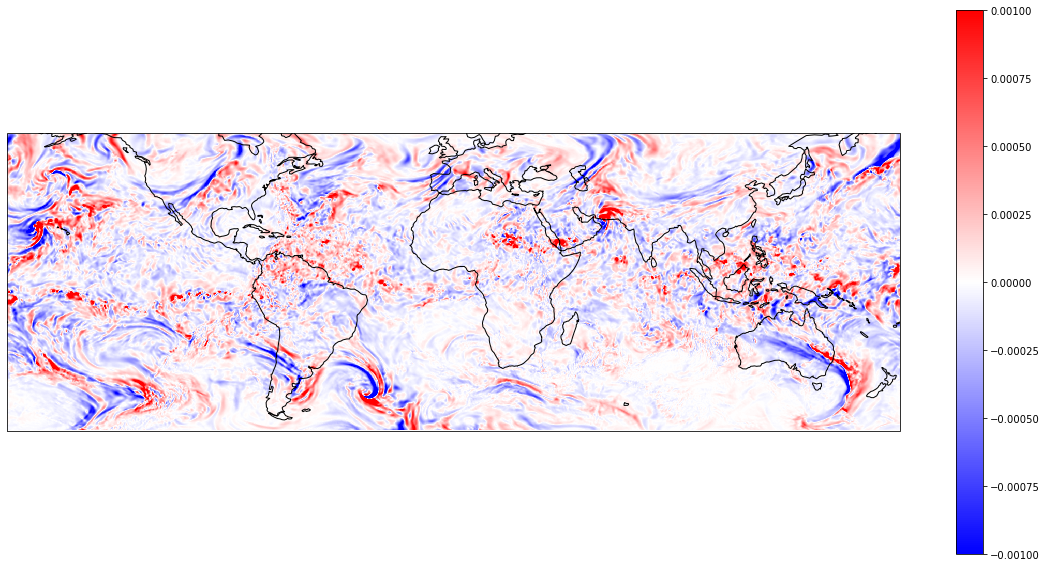

In [63]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20, 10)


# ax.contourf(e5data.longitude.values, e5data.latitude.values[1:-1], vimfd, levels=np.percentile(vimfd, np.arange(0, 100, 5)))
im = ax.imshow(-vimfd, origin='lower', extent=(0, 360, -60, 60), cmap='bwr', vmin=-0.001, vmax=0.001)
ax.coastlines()
ax.set_ylim((-60, 60))
plt.colorbar(im)

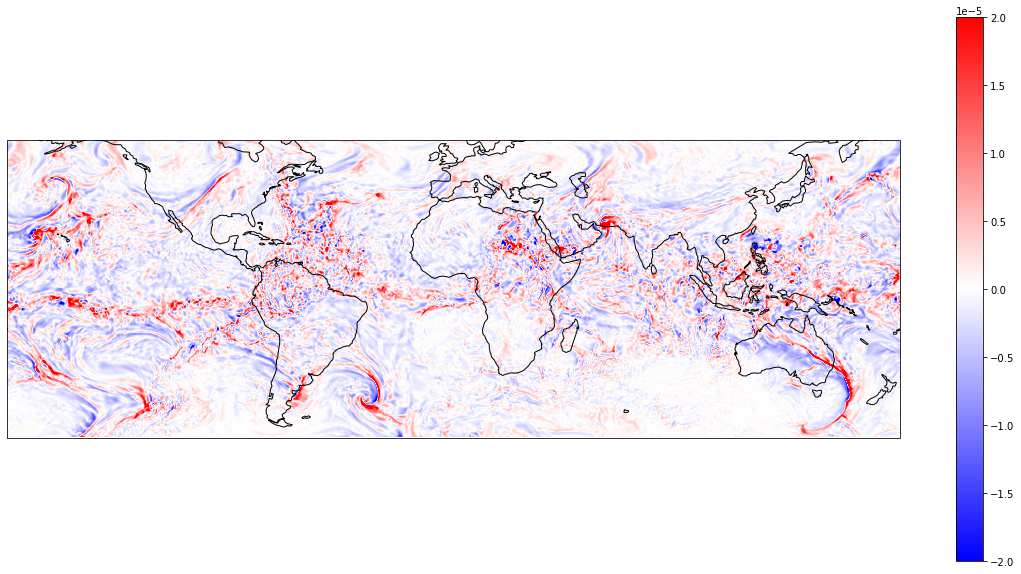

In [62]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20, 10)


# ax.contourf(e5data.longitude.values, e5data.latitude.values[1:-1], vimfd, levels=np.percentile(vimfd, np.arange(0, 100, 5)))
im = ax.imshow(-div_mf.sum(axis=0), origin='lower', extent=(0, 360, -60, 60), cmap='bwr', vmin=-0.00002, vmax=0.00002)
ax.coastlines()
ax.set_ylim((-60, 60))
plt.colorbar(im)

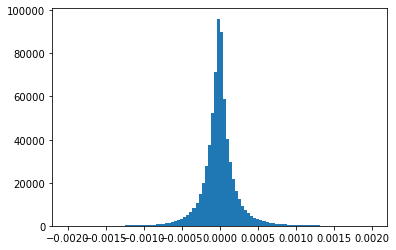

In [56]:
plt.hist(-vimfd.flatten(), bins=np.linspace(-0.002, 0.002, 101));

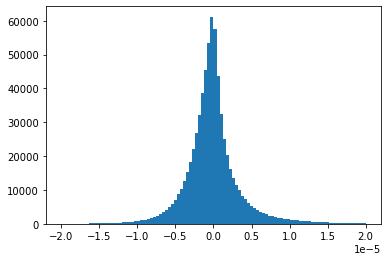

In [59]:
plt.hist(-div_mf.sum(axis=0).flatten(), bins=np.linspace(-0.00002, 0.00002, 101));

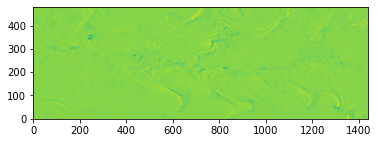

In [29]:
plt.imshow(vimfd, origin='lower')

In [ ]:
np.percentile(vimfd, np.arange(0, 100, 11))

In [34]:
vimfd.sum()

2.2105714909998833

In [35]:
np.percentile(vimfd, np.arange(0, 100, 11))

array([-1.40159812e-02, -2.09804593e-04, -9.82973916e-05, -4.15244242e-05,
       -6.45513855e-06,  2.34657583e-05,  6.08586625e-05,  1.13157948e-04,
        2.05697766e-04,  6.92166132e-04])